# Module 07: Generalized Linear Models

**CS229 Aligned Curriculum** | *Gold Standard Edition*

## 0. What Are Generalized Linear Models?

### The Big Picture

Alright, let's talk about one of the most elegant frameworks in statistics: **Generalized Linear Models (GLM)**.

Here's the key insight: Linear Regression assumes your errors are Gaussian (normally distributed). That works great for a lot of problems. But what if you're predicting counts (which can't be negative)? Or binary outcomes (0 or 1)? Or waiting times (always positive)?

That's where GLM comes in. It's a unified framework that extends linear regression to handle different types of data distributions, not just Gaussian. Same core principles, just more flexible.

**The Three Components:**
1. **Random Component:** $y|x \sim$ Exponential Family (Bernoulli, Poisson, Gaussian, etc.)
2. **Systematic Component:** $\eta = \theta^T x$ (our familiar linear predictor)
3. **Link Function:** $g(\mu) = \eta$ (connects the mean to our linear predictor)

---

### When to Use Generalized Linear Models (GLM)?

| Scenario | Use It | Don't Use |
|----------|---------|----------------|
| **Count data (integers)** | Poisson Regression | Linear Regression (predicts decimals/negatives) |
| **Binary data (0/1)** | Logistic Regression | Linear Regression |
| **Waiting time (positive)** | Gamma/Exponential Regression | Linear Regression |
| **Standard Normal Errors** | Linear Regression (Gaussian GLM) | - |

---

### Real-World Examples:

- **Call Center**: Predicting call volume per hour (Poisson)
- **Insurance**: Predicting claim count (Poisson) or claim amount (Gamma)
- **Web Traffic**: Hits per day analysis
- **Quality Control**: Number of defects per batch


---

## PART 1: The Exponential Family (One Family to Rule Them All)

Here's something beautiful: Linear Regression (Gaussian), Logistic Regression (Bernoulli), and Count Regression (Poisson) are all part of the same family. Seriously!

They all follow this general template:

$$p(y; \eta) = b(y) \exp(\eta^T T(y) - a(\eta))$$

This is the exponential family in all its glory. Different distributions are just different choices of functions $b$, $T$, and $a$.

### The Exponential Family Cheat Sheet

| Distribution | Natural Param ($\eta$) | Mean ($\mu$) | Variance $V(\mu)$ | Canonical Link |
| :--- | :--- | :--- | :--- | :--- |
| **Gaussian** | $\mu/\sigma^2$ | $\eta\sigma^2$ | $\sigma^2$ | Identity |
| **Bernoulli** | $\log(\mu/(1-\mu))$ | $1/(1+e^{-\eta})$ | $\mu(1-\mu)$ | Logit (Sigmoid) |
| **Gamma** | $-1/\mu$ | $-1/\eta$ | $\mu^2/k$ | Inverse |
| **Poisson** | $\log(\mu)$ | $e^{\eta}$ | $\mu$ | Log |


You don't need to memorize this table – just know it exists. The key takeaway is that these seemingly different distributions all follow the same underlying structure.

## PART 2: The Unified GLM Framework

**Why does the exponential family matter?** Because once you know your target variable follows some exponential family distribution, you automatically get a clean, principled way to build a regression model. The GLM framework gives you a recipe that works for *any* member of this family.

Alright, let's see how GLM ties everything together. The framework connects our linear combination of inputs ($\eta = \theta^T x$) to the target prediction ($h(x)$) through a **link function** ($g$).

### The 3 Crucial Assumptions:
1. **Random Component:** $y \mid x; \theta \sim \text{ExpFamily}(\eta)$ (your target follows some exponential family distribution)
2. **Systematic Component:** $\eta = \theta^T x$ (good old linear predictor)
3. **Link Function:** $\eta = g(\mu)$, or equivalently: $\mu = g^{-1}(\eta)$ (connects the mean to the linear part)

These three pieces are all you need to define any GLM. Pretty elegant, right?

## PART 3: The Engine - How Computers Actually Fit GLMs

You might be wondering: "Okay, this framework is nice, but how do we actually estimate $\theta$?" Great question!

Instead of regular Gradient Descent, GLMs typically use something called **IRLS** (Iteratively Reweighted Least Squares). It's basically an efficient version of Newton-Raphson that exploits the structure of exponential family distributions.

### Why IRLS Instead of Gradient Descent?

Here's the thing: Gradient Descent treats every data point the same - it takes equal-sized steps regardless of where you are in parameter space. But GLMs are smarter. Different distributions have different **variance structures**, and IRLS exploits this.

Think of it like this: if you're navigating terrain, wouldn't you want to take bigger steps on flat ground (low uncertainty) and smaller, more careful steps on steep slopes (high uncertainty)? That's exactly what IRLS does - it **reweights** each observation based on how certain the model is about that prediction.

### How IRLS Works:

At each iteration, we solve a weighted least squares problem:

$$\theta^{(k+1)} = (X^T W X)^{-1} X^T W z$$

where:

- $W$ = Weight matrix based on the **variance function** of your distribution
  - Gaussian: constant weights (all equal)
  - Bernoulli: $w_i = \mu_i(1-\mu_i)$ (lower weight near 0 and 1, higher near 0.5)
  - Poisson: $w_i = \mu_i$ (higher counts get more weight)
- $z$ = "Working response" (a linearized version of the target that accounts for the link function)

**The beautiful part:** Each iteration solves a standard weighted least squares problem, which has a closed-form solution. This is typically much faster than gradient descent, especially for smaller datasets.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
from sklearn.linear_model import LinearRegression, LogisticRegression, PoissonRegressor, GammaRegressor

class GLMScratch:
    """GLM from scratch using IRLS. Supports: Gaussian, Bernoulli, Poisson."""
    
    def __init__(self, family='gaussian', max_iter=20, tol=1e-6):
        self.family = family
        self.max_iter = max_iter
        self.tol = tol
        self.theta = None
        
    def _link_inv(self, eta):
        """g^-1(eta): maps linear predictor to mean"""
        if self.family == 'gaussian': return eta
        if self.family == 'bernoulli': return 1 / (1 + np.exp(-eta))
        if self.family == 'poisson': return np.exp(eta)
        return eta
    
    def _variance_func(self, mu):
        """V(mu): variance as function of mean"""
        if self.family == 'gaussian': return np.ones_like(mu)
        if self.family == 'bernoulli': return mu * (1 - mu)
        if self.family == 'poisson': return mu
        return np.ones_like(mu)
    
    def fit(self, X, y):
        """fit GLM via IRLS"""
        y = np.asarray(y).reshape(-1, 1)
        n_samples, n_features = X.shape
        X_b = np.c_[np.ones(n_samples), X]
        self.theta = np.zeros((n_features + 1, 1))
        
        for i in range(self.max_iter):
            # forward pass
            eta = X_b @ self.theta
            mu = self._link_inv(eta)
            
            # compute weights (inverse of variance)
            weights = self._variance_func(mu)
            
            # working response (linearized target)
            z = eta + (y - mu) / (weights + 1e-8)
            
            # solve weighted least squares: theta = (X^T W X)^-1 X^T W z
            XTWX = X_b.T @ (weights * X_b)
            XTWz = X_b.T @ (weights * z)
            
            try:
                new_theta = np.linalg.solve(XTWX, XTWz)
            except np.linalg.LinAlgError:
                new_theta = np.linalg.pinv(XTWX) @ XTWz
                
            # check convergence
            if np.linalg.norm(new_theta - self.theta) < self.tol:
                self.theta = new_theta
                print(f"Converged in {i+1} iterations.")
                break
            self.theta = new_theta

    def predict(self, X):
        """return E[y|X]"""
        X_b = np.c_[np.ones(X.shape[0]), X]
        return self._link_inv(X_b @ self.theta).ravel()
    
    def predict_proba(self, X):
        """alias for Bernoulli classification"""
        return self.predict(X)

print("GLM Scratch Engine (Optimized IRLS) Ready!")

GLM Scratch Engine (Optimized IRLS) Ready!


## PART 4: Testing the Framework (Five Case Studies)

Alright, theory is great, but now comes the fun part: seeing this in action.


We'll test our GLM implementation on five different types of data. Each one will show you exactly when and why choosing the right distribution matters. By the end, you'll have an intuition for which GLM to reach for when you see a new dataset.

4.1 GAUSSIAN GLM: LINEAR REGRESSION FROM SCRATCH

True Relationship: y = 2.5*X + 5 + N(0, 2.0^2)

OLS from Scratch:
   Bias (intercept): 4.8575 (True: 5)
   Theta (slope):    2.4811 (True: 2.5)

Sklearn OLS:
   Bias (intercept): 4.8575
   Theta (slope):    2.4811


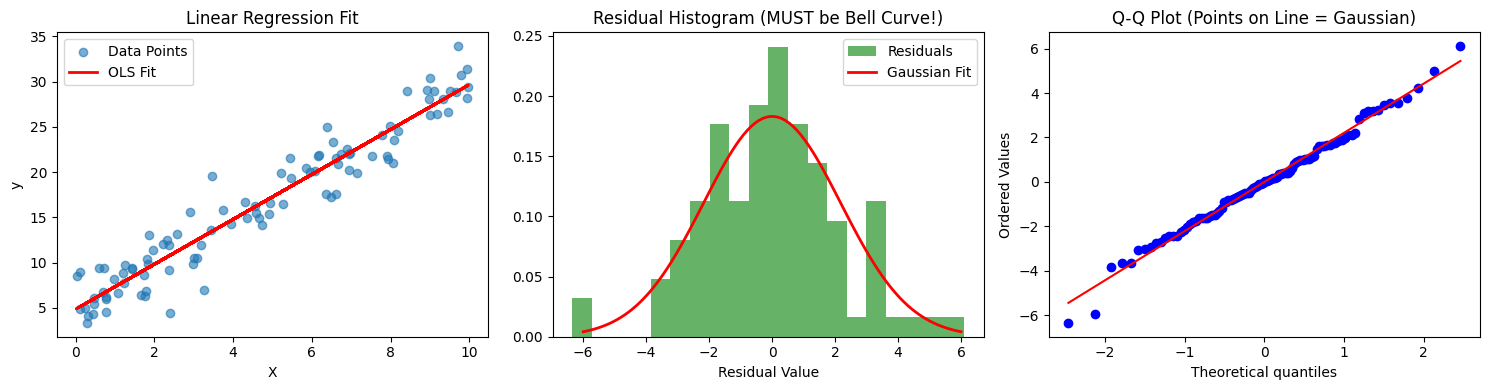


Conclusion: Residuals form a bell curve (Gaussian). GLM assumption verified!
This confirms that Linear Regression (Gaussian GLM) is appropriate for this data.


In [2]:
# --- 4.1 Gaussian GLM (Linear Regression) ---
print("="*60)
print("4.1 GAUSSIAN GLM: LINEAR REGRESSION FROM SCRATCH")
print("="*60)

# generate data with Gaussian noise
n_samples = 100
X_gauss = np.random.rand(n_samples, 1) * 10
true_theta = 2.5
true_bias = 5
noise_std = 2.0
noise = np.random.normal(0, noise_std, size=(n_samples, 1))
y_gauss = true_theta * X_gauss + true_bias + noise

print(f"\nTrue Relationship: y = {true_theta}*X + {true_bias} + N(0, {noise_std}^2)")

# OLS from scratch via normal equation: theta = (X^T X)^(-1) X^T y
X_b = np.c_[np.ones((n_samples, 1)), X_gauss]
theta_scratch = np.linalg.inv(X_b.T @ X_b) @ X_b.T @ y_gauss

print(f"\nOLS from Scratch:")
print(f"   Bias (intercept): {theta_scratch[0][0]:.4f} (True: {true_bias})")
print(f"   Theta (slope):    {theta_scratch[1][0]:.4f} (True: {true_theta})")

# validation with sklearn
model_ols = LinearRegression()
model_ols.fit(X_gauss, y_gauss)
print(f"\nSklearn OLS:")
print(f"   Bias (intercept): {model_ols.intercept_[0]:.4f}")
print(f"   Theta (slope):    {model_ols.coef_[0][0]:.4f}")

# residual analysis (PROOF that Gaussian assumption is correct)
y_pred_ols = model_ols.predict(X_gauss)
residuals = y_gauss - y_pred_ols

fig, axes = plt.subplots(1, 3, figsize=(15, 4))

# data + fit
axes[0].scatter(X_gauss, y_gauss, alpha=0.6, label='Data Points')
axes[0].plot(X_gauss, y_pred_ols, color='red', linewidth=2, label='OLS Fit')
axes[0].set_xlabel('X'); axes[0].set_ylabel('y')
axes[0].set_title('Linear Regression Fit')
axes[0].legend()

# residual histogram (should be bell curve!)
axes[1].hist(residuals, bins=20, density=True, alpha=0.6, color='green', label='Residuals')
x_range = np.linspace(-6, 6, 100)
axes[1].plot(x_range, stats.norm.pdf(x_range, 0, np.std(residuals)), 'r-', lw=2, label='Gaussian Fit')
axes[1].set_title('Residual Histogram (MUST be Bell Curve!)')
axes[1].set_xlabel('Residual Value'); axes[1].legend()

# Q-Q plot (better normality check)
stats.probplot(residuals.ravel(), dist="norm", plot=axes[2])
axes[2].set_title('Q-Q Plot (Points on Line = Gaussian)')

plt.tight_layout()
plt.show()

print("\nConclusion: Residuals form a bell curve (Gaussian). GLM assumption verified!")
print("This confirms that Linear Regression (Gaussian GLM) is appropriate for this data.")



4.2 BERNOULLI GLM: LOGISTIC REGRESSION FROM SCRATCH

Logistic Regression from Scratch:
   Theta (bias, w1, w2): [0.3841 4.05   3.4117]

Sklearn Logistic Regression:
   Theta: [ -0.3828 176.8352 164.2704]


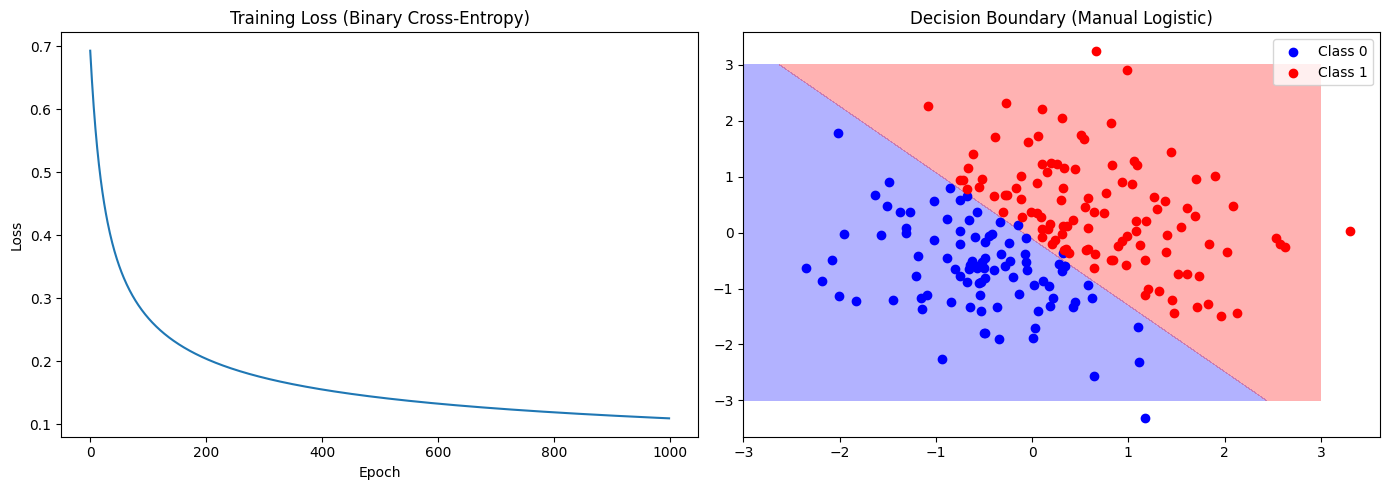


Point-wise Verification at X = [1.5, 0.5]:
   Eta (logit):      8.1649
   Manual sigmoid:   0.9997
   Sklearn prob:     1.0000
   Match?            True

Our manual implementation matches sklearn - the math checks out!


In [3]:
# --- 4.2 Bernoulli GLM (Logistic Regression) ---
print("\n" + "="*60)
print("4.2 BERNOULLI GLM: LOGISTIC REGRESSION FROM SCRATCH")
print("="*60)

# generate binary classification data
X_bernoulli = np.random.randn(200, 2)
y_bernoulli = ((X_bernoulli[:, 0] + X_bernoulli[:, 1]) > 0).astype(int)

def sigmoid(z):
    """phi = 1 / (1 + e^(-eta))"""
    return 1 / (1 + np.exp(-z))

def logistic_regression_scratch(X, y, lr=0.1, epochs=1000):
    """train logistic regression via gradient descent"""
    m, n = X.shape
    X_b = np.c_[np.ones((m, 1)), X]
    theta = np.zeros(n + 1)
    
    losses = []
    for epoch in range(epochs):
        # forward: eta = theta^T x, phi = sigmoid(eta)
        eta = X_b @ theta
        phi = sigmoid(eta)
        
        # binary cross-entropy loss
        loss = -np.mean(y * np.log(phi + 1e-8) + (1 - y) * np.log(1 - phi + 1e-8))
        losses.append(loss)
        
        # gradient: d/dtheta = (1/m) * X^T @ (phi - y)
        gradient = (1/m) * X_b.T @ (phi - y)
        theta -= lr * gradient
    
    return theta, losses

theta_manual, losses = logistic_regression_scratch(X_bernoulli, y_bernoulli)

print(f"\nLogistic Regression from Scratch:")
print(f"   Theta (bias, w1, w2): {np.round(theta_manual, 4)}")

# validation with sklearn
model_logistic = LogisticRegression(penalty=None, solver='lbfgs')
model_logistic.fit(X_bernoulli, y_bernoulli)
print(f"\nSklearn Logistic Regression:")
print(f"   Theta: {np.round(np.r_[model_logistic.intercept_, model_logistic.coef_[0]], 4)}")

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# loss curve
axes[0].plot(losses)
axes[0].set_title('Training Loss (Binary Cross-Entropy)')
axes[0].set_xlabel('Epoch'); axes[0].set_ylabel('Loss')

# decision boundary
xx, yy = np.meshgrid(np.linspace(-3, 3, 100), np.linspace(-3, 3, 100))
X_grid = np.c_[xx.ravel(), yy.ravel()]
X_grid_b = np.c_[np.ones((X_grid.shape[0], 1)), X_grid]
Z = sigmoid(X_grid_b @ theta_manual).reshape(xx.shape)

axes[1].contourf(xx, yy, Z, levels=[0, 0.5, 1], alpha=0.3, colors=['blue', 'red'])
axes[1].scatter(X_bernoulli[y_bernoulli==0, 0], X_bernoulli[y_bernoulli==0, 1], c='blue', label='Class 0')
axes[1].scatter(X_bernoulli[y_bernoulli==1, 0], X_bernoulli[y_bernoulli==1, 1], c='red', label='Class 1')
axes[1].set_title('Decision Boundary (Manual Logistic)')
axes[1].legend()

plt.tight_layout()
plt.show()

# point-wise verification
test_point = [[1.5, 0.5]]
eta_manual = np.r_[1, test_point[0]] @ theta_manual
prob_manual = sigmoid(eta_manual)
prob_sklearn = model_logistic.predict_proba(test_point)[0][1]

print(f"\nPoint-wise Verification at X = {test_point[0]}:")
print(f"   Eta (logit):      {eta_manual:.4f}")
print(f"   Manual sigmoid:   {prob_manual:.4f}")
print(f"   Sklearn prob:     {prob_sklearn:.4f}")
print(f"   Match?            {np.isclose(prob_manual, prob_sklearn, atol=0.05)}")
print("\nOur manual implementation matches sklearn - the math checks out!")



4.3 POISSON GLM: WHY LINEAR REGRESSION FAILS FOR COUNT DATA

True Relationship: E[y|x] = exp(0.25 * x)
   Data range: X ∈ [0, 10], y ∈ [0, 13]


c:\Users\test\AppData\Local\Programs\Python\Python39\lib\site-packages\joblib\externals\loky\backend\context.py:136: UserWarning: Could not find the number of physical cores for the following reason:
[WinError 2] The system cannot find the file specified
Returning the number of logical cores instead. You can silence this warning by setting LOKY_MAX_CPU_COUNT to the number of cores you want to use.
  warnings.warn(
  File "c:\Users\test\AppData\Local\Programs\Python\Python39\lib\site-packages\joblib\externals\loky\backend\context.py", line 257, in _count_physical_cores
    cpu_info = subprocess.run(
  File "c:\Users\test\AppData\Local\Programs\Python\Python39\lib\subprocess.py", line 505, in run
    with Popen(*popenargs, **kwargs) as process:
  File "c:\Users\test\AppData\Local\Programs\Python\Python39\lib\subprocess.py", line 951, in __init__
    self._execute_child(args, executable, preexec_fn, close_fds,
  File "c:\Users\test\AppData\Local\Programs\Python\Python39\lib\subprocess.py"

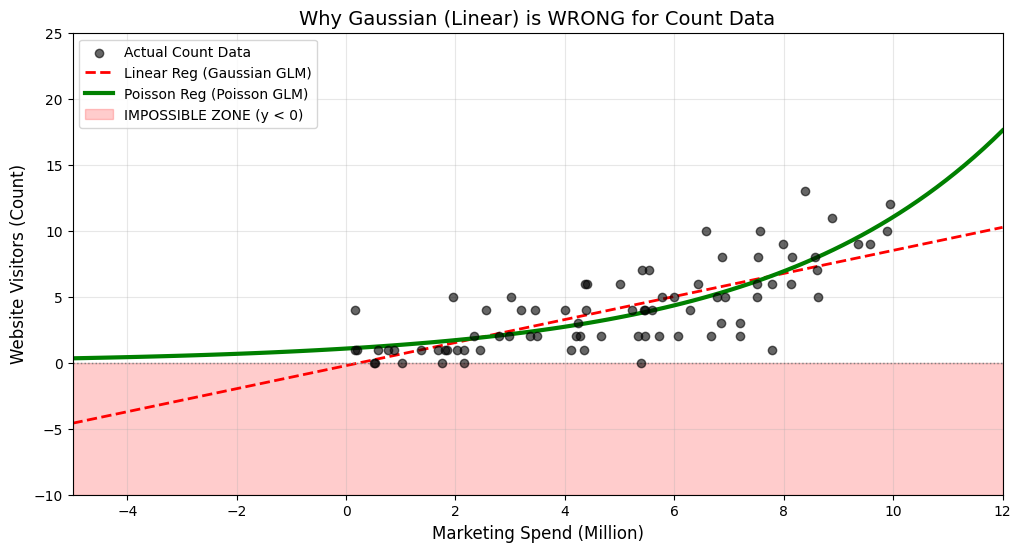


Prediction at X = -3 (Extrapolation):
   Linear Regression: -2.84 visitors (NEGATIVE! Impossible!)
   Poisson Regression: 0.53 visitors (Positive, makes sense)

The key insight: Poisson GLM respects the constraints of count data (y >= 0, discrete).
Linear regression can predict impossible values; GLM ensures predictions are always valid.


In [4]:
# --- 4.3 Poisson GLM (Count Regression) ---
print("\n" + "="*60)
print("4.3 POISSON GLM: WHY LINEAR REGRESSION FAILS FOR COUNT DATA")
print("="*60)

# generate count data (website visitors based on marketing spend)
X_poisson = np.sort(np.random.rand(80) * 10)[:, np.newaxis]
# true relationship: lambda = exp(0.25 * X), count ~ Poisson(lambda)
true_lambda = np.exp(0.25 * X_poisson).ravel()
y_poisson = np.random.poisson(true_lambda)

print(f"\nTrue Relationship: E[y|x] = exp(0.25 * x)")
print(f"   Data range: X ∈ [0, 10], y ∈ [{y_poisson.min()}, {y_poisson.max()}]")

# train both models
model_linear_wrong = LinearRegression().fit(X_poisson, y_poisson)
model_poisson_right = PoissonRegressor(alpha=0, max_iter=1000).fit(X_poisson, y_poisson)

# test at NEGATIVE X values (extrapolation) - this is where linear breaks!
X_test_range = np.linspace(-5, 12, 100)[:, np.newaxis]
y_pred_linear = model_linear_wrong.predict(X_test_range)
y_pred_poisson = model_poisson_right.predict(X_test_range)

plt.figure(figsize=(12, 6))
plt.scatter(X_poisson, y_poisson, color='black', alpha=0.6, label='Actual Count Data', zorder=5)
plt.plot(X_test_range, y_pred_linear, color='red', linestyle='--', linewidth=2, label='Linear Reg (Gaussian GLM)')
plt.plot(X_test_range, y_pred_poisson, color='green', linewidth=3, label='Poisson Reg (Poisson GLM)')
plt.axhline(0, color='gray', linestyle=':', linewidth=1)
plt.fill_between(X_test_range.ravel(), -10, 0, alpha=0.2, color='red', label='IMPOSSIBLE ZONE (y < 0)')

plt.title('Why Gaussian (Linear) is WRONG for Count Data', fontsize=14)
plt.xlabel('Marketing Spend (Million)', fontsize=12)
plt.ylabel('Website Visitors (Count)', fontsize=12)
plt.legend(loc='upper left')
plt.xlim(-5, 12); plt.ylim(-10, 25)
plt.grid(True, alpha=0.3)
plt.show()

# specific prediction comparison
test_negative = [[-3]]
pred_lin = model_linear_wrong.predict(test_negative)[0]
pred_pois = model_poisson_right.predict(test_negative)[0]

print(f"\nPrediction at X = -3 (Extrapolation):")
print(f"   Linear Regression: {pred_lin:.2f} visitors (NEGATIVE! Impossible!)")
print(f"   Poisson Regression: {pred_pois:.2f} visitors (Positive, makes sense)")

print("\nThe key insight: Poisson GLM respects the constraints of count data (y >= 0, discrete).")
print("Linear regression can predict impossible values; GLM ensures predictions are always valid.")



4.4 MULTINOMIAL GLM: SOFTMAX REGRESSION FROM SCRATCH

Dataset: 300 samples, 4 features, 3 classes

Model Weights:
   W shape: (3, 4) (n_classes x n_features)
   b shape: (3,) (n_classes,)

For sample index 5:
   Raw Logits (eta):     [ 1.083   2.177  -3.2601]
   Manual Softmax (phi): [0.2501 0.7467 0.0032]
   Sklearn predict_proba: [0.2501 0.7467 0.0032]

Manual Softmax matches Sklearn? True
Notice how the probabilities sum to 1.0 - this is the softmax constraint.


c:\Users\test\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


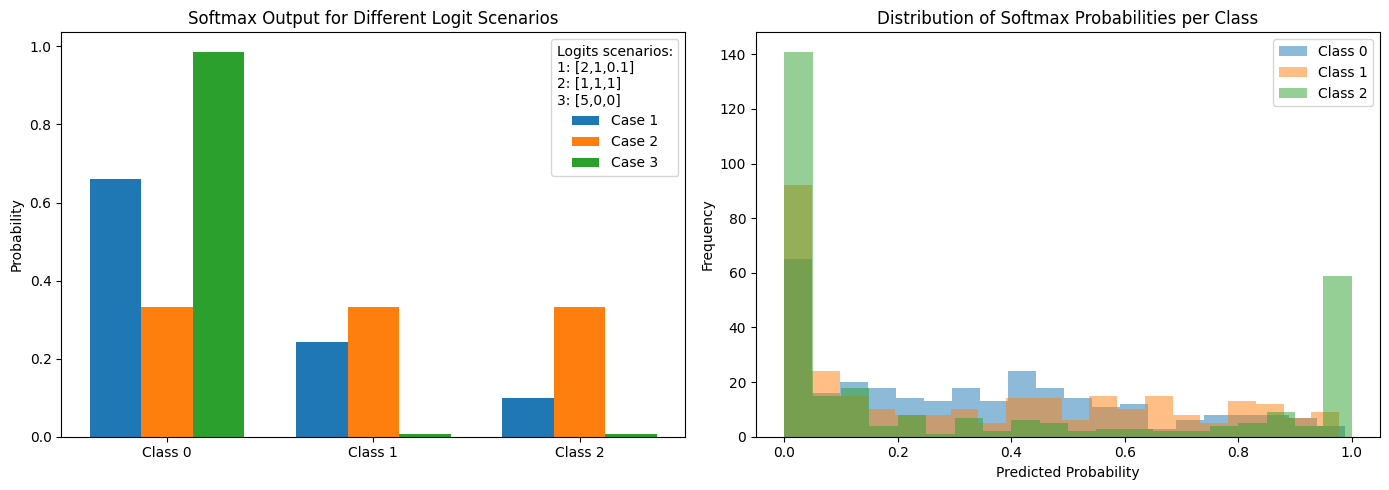


Congratulations! You've mastered the exponential family.
Now you understand the deep connection between different ML algorithms.
They're not separate techniques - they're all GLMs with different distributions!

Key Insight: Linear, Logistic, Poisson, and Softmax Regression are all
just different choices of (1) distribution, (2) link function, and (3) variance function.


In [5]:
from sklearn.datasets import make_classification
# --- 4.4 Multinomial GLM (Softmax Regression) ---
print("\n" + "="*60)
print("4.4 MULTINOMIAL GLM: SOFTMAX REGRESSION FROM SCRATCH")
print("="*60)

def softmax(logits):
    """phi_i = exp(eta_i) / sum(exp(eta_j))"""
    # numerical stability: subtract max
    logits_stable = logits - np.max(logits, axis=-1, keepdims=True)
    exp_logits = np.exp(logits_stable)
    return exp_logits / np.sum(exp_logits, axis=-1, keepdims=True)

# generate multi-class data (3 classes)
X_multi, y_multi = make_classification(
    n_samples=300, n_features=4, n_classes=3, 
    n_clusters_per_class=1, n_informative=3, n_redundant=0, random_state=42
)
print(f"\nDataset: {X_multi.shape[0]} samples, {X_multi.shape[1]} features, 3 classes")

# train sklearn softmax (multinomial logistic)
model_softmax = LogisticRegression(multi_class='multinomial', solver='lbfgs', max_iter=500)
model_softmax.fit(X_multi, y_multi)

# extract weights for manual verification
W = model_softmax.coef_  # (3, 4)
b = model_softmax.intercept_  # (3,)

print(f"\nModel Weights:")
print(f"   W shape: {W.shape} (n_classes x n_features)")
print(f"   b shape: {b.shape} (n_classes,)")

# point-wise calculation
test_idx = 5
x_test = X_multi[test_idx].reshape(1, -1)  # (1, 4)

# compute logits: eta = W @ x + b
logits = (x_test @ W.T + b)  # (1, 3)
print(f"\nFor sample index {test_idx}:")
print(f"   Raw Logits (eta):     {np.round(logits[0], 4)}")

# apply manual softmax
probs_manual = softmax(logits)
print(f"   Manual Softmax (phi): {np.round(probs_manual[0], 4)}")

# compare with sklearn
probs_sklearn = model_softmax.predict_proba(x_test)
print(f"   Sklearn predict_proba: {np.round(probs_sklearn[0], 4)}")

is_match = np.allclose(probs_manual, probs_sklearn, atol=1e-4)
print(f"\nManual Softmax matches Sklearn? {is_match}")
print("Notice how the probabilities sum to 1.0 - this is the softmax constraint.")

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# how softmax transforms logits
example_logits = np.array([[2.0, 1.0, 0.1], [1.0, 1.0, 1.0], [5.0, 0.0, 0.0]])
example_probs = softmax(example_logits)

x_pos = np.arange(3)
width = 0.25
for i in range(3):
    axes[0].bar(x_pos + i*width, example_probs[i], width, label=f'Case {i+1}')
axes[0].set_xticks(x_pos + width)
axes[0].set_xticklabels(['Class 0', 'Class 1', 'Class 2'])
axes[0].set_ylabel('Probability')
axes[0].set_title('Softmax Output for Different Logit Scenarios')
axes[0].legend(title='Logits scenarios:\n1: [2,1,0.1]\n2: [1,1,1]\n3: [5,0,0]')

# per-class prediction distribution
all_probs = model_softmax.predict_proba(X_multi)
for i in range(3):
    axes[1].hist(all_probs[:, i], bins=20, alpha=0.5, label=f'Class {i}')
axes[1].set_xlabel('Predicted Probability')
axes[1].set_ylabel('Frequency')
axes[1].set_title('Distribution of Softmax Probabilities per Class')
axes[1].legend()

plt.tight_layout()
plt.show()

print("\nCongratulations! You've mastered the exponential family.")
print("Now you understand the deep connection between different ML algorithms.")
print("They're not separate techniques - they're all GLMs with different distributions!")
print("\nKey Insight: Linear, Logistic, Poisson, and Softmax Regression are all")
print("just different choices of (1) distribution, (2) link function, and (3) variance function.")


### 4.5 Gamma GLM: For Strictly Positive Continuous Data

Here's the thing about real-world data: sometimes your target variable is continuous AND must be positive. Linear regression can predict negative values, which makes no sense for things like insurance claims or waiting times.

**When do we use Gamma GLM?**
- **Insurance claim amounts** (always positive, usually right-skewed)
- **Waiting times** (can't be negative, often have a long tail)
- **Any continuous data that's strictly positive** (y > 0) and right-skewed

The Gamma distribution handles this perfectly - it's designed for positive continuous data with a natural skew.


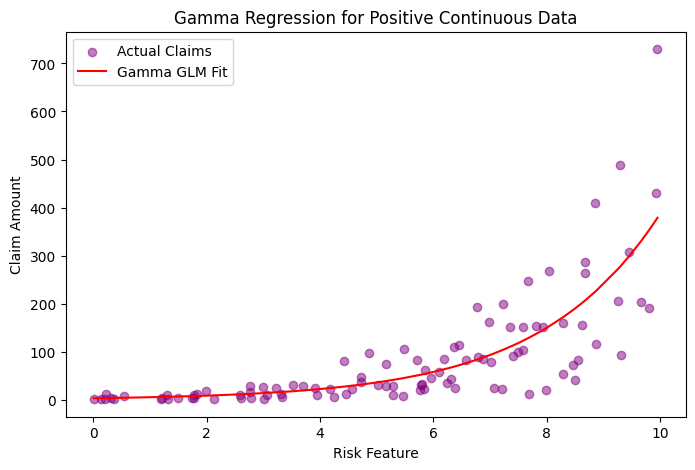

Gamma Model R^2: 0.7291
Gamma GLM ensures predictions are always positive - perfect for claim amounts!


In [6]:
# generate gamma distributed data (insurance claims)
X_gamma = np.random.rand(100, 1) * 10
mu_gamma = np.exp(0.5 * X_gamma + 1).ravel()
y_gamma = np.random.gamma(shape=2.0, scale=mu_gamma/2.0)

model_gamma = GammaRegressor(alpha=0, max_iter=1000).fit(X_gamma, y_gamma)
y_pred_gamma = model_gamma.predict(X_gamma)

plt.figure(figsize=(8, 5))
plt.scatter(X_gamma, y_gamma, color='purple', alpha=0.5, label='Actual Claims')
plt.plot(np.sort(X_gamma, axis=0), np.sort(y_pred_gamma), color='red', label='Gamma GLM Fit')
plt.title("Gamma Regression for Positive Continuous Data")
plt.xlabel("Risk Feature"); plt.ylabel("Claim Amount")
plt.legend(); plt.show()

print(f"Gamma Model R^2: {model_gamma.score(X_gamma, y_gamma):.4f}")
print("Gamma GLM ensures predictions are always positive - perfect for claim amounts!")


## PART 5: Model Diagnostics (Is Our GLM Actually Good?)

Alright, so we've fit our models. But here's the thing: just because your code runs doesn't mean you picked the right distribution.

How do we actually know if our GLM is appropriate for the data? This is where diagnostics come in. GLMs need more careful residual checking than regular OLS regression, because the assumptions are more subtle - you're not just checking for normality, you're checking whether the **variance structure** matches your chosen distribution.

For example:
- **Gaussian GLM**: Residuals should have constant variance (homoscedasticity)
- **Poisson GLM**: Variance should grow with the mean (heteroscedasticity is expected!)
- **Bernoulli GLM**: Variance should be highest near probability 0.5

The key insight: different distributions have different **mean-variance relationships**. If you see patterns in your residual plots that violate these relationships, you've probably chosen the wrong family.

In [ ]:
def plot_glm_diagnostics(y_true, y_pred):
    residuals = y_true - y_pred
    fig, axes = plt.subplots(1, 2, figsize=(12, 5))
    
    axes[0].scatter(y_pred, residuals, alpha=0.5)
    axes[0].axhline(0, color='red', linestyle='--')
    axes[0].set_title("Residuals vs Fitted")
    axes[0].set_xlabel("Predicted"); axes[0].set_ylabel("Residuals")
    
    stats.probplot(residuals, dist="norm", plot=axes[1])
    axes[1].set_title("Normal Q-Q")
    
    plt.tight_layout(); plt.show()

print("Diagnostic suite ready.")
print("Use this to check if your chosen distribution actually fits the data.")

## THEORETICAL APPENDIX: The MLE Derivation (For the Math Lovers)

Okay, math time. This section is optional, but if you're the kind of person who needs to see where things come from, this one's for you.

We're about to derive the **score function** for the exponential family from first principles. Why does this matter? Because once you see this derivation, you'll understand why seemingly different algorithms (linear regression, logistic regression, Poisson regression) all end up with the same gradient structure. It's all connected.

Don't worry if this looks heavy - I'll walk you through it step by step, and there's a beautiful insight at the end that makes it all worth it.

---

The log-likelihood for the exponential family is:

$$\ell(\theta) = \sum_{i=1}^n \log b(y_i) + \eta_i y_i - a(\eta_i)$$

Taking the derivative with respect to $\theta$ (using the chain rule):

$$\frac{\partial \ell}{\partial \theta} = \sum_{i=1}^n (y_i - a'(\eta_i)) \frac{\partial \eta_i}{\partial \theta}$$

Now here's the beautiful part: for the exponential family, $a'(\eta) = \mu$ (the expected value), and we know that $\eta = \theta^T x$, which means $\frac{\partial \eta_i}{\partial \theta} = x_i$.

Substituting these facts:

$$\nabla_\theta \ell = \sum_{i=1}^n (y_i - \mu_i) x_i$$

And there it is! The gradient always has this **(Error × Input)** form, regardless of which exponential family member you're using. This is the mathematical foundation that unifies all GLM update rules - from linear regression to logistic to Poisson, they all follow this same elegant structure.

# CAPSTONE: Medical Insurance Claims Analysis

### Dataset: Medical Insurance

Alright, time to put everything together!

You've learned the theory, seen the individual examples, and now it's time for the ultimate test: a complete end-to-end analysis on messy, real-world data. No more synthetic examples - this is the real deal.

Our target is `charges` (medical insurance costs) - a continuous positive variable that's heavily right-skewed. Translation: this is *exactly* the kind of data where Linear Regression fails and Gamma GLM shines. You're about to see the framework pay off.

**Your Mission:**
1. **EDA First**: Visualize the target distribution and prove it's NOT Gaussian (spoiler: it won't even be close)
2. **Model Showdown**: Fit both Linear Regression and Gamma Regression head-to-head
3. **Statistical Proof**: Use AIC (Akaike Information Criterion) to quantify which model is better - no hand-waving, just math
4. **Visual Diagnosis**: Plot residuals and see the difference with your own eyes

Here's what you'll discover: Linear Regression will make predictions that violate reality (negative costs!), while Gamma GLM respects the constraints of the data. This is where theory meets practice, and you'll finally understand why choosing the right distribution isn't just academic - it directly affects your model's quality in production.

Ready? Let's do this.